# EDA and data preparation
This file includes the following parts: 
- Choose what subreddits will be used for our analysis (we will use 2 or 4 depending on time and scope of the project).
- Create the appropriate dataset by combining the data from the desired subreddits of interest.
- Start EDA on the dataset of interest and observe any possible trends/relations/clues.
- Summarize the findings and recommendations to be used for the modeling part.
- Repeat the same process in case other subreddits are intended to be investigated.

In [1]:

# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import os # to check for file existance

# for time conversion
from datetime import datetime
import re   # for regex
# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

## 'offmychest' and 'relationship_advice' subreddits
---
In this section, we have investigated two subreddits and tried to see if we can observe any interesting points by doing EDA. The two subreddits of interest are r/offmychest and r/relationship_advice. Both subreddits have a relatively high number of listings per day so this will give us enough information to investigate on. offmychest subreddit mostly contains listings about personal issues, emotional hardships, life problems, and also issues in peoples relationships. The subreddit usually does have a sad tone because people use it as a way to express their feelings, unburden some thoughts, or to confess about things. relationship_advice subreddit focuses more on relationships and the ups and downs in it. <br>
The reasons these two subreddits were used for our investigation is that while these two subreddits represent two topics that could be distinguishable from each other, they do have common points that could make the classification process challenging. Although offmychest includes a wide variety of subjects, it often includes topics which are related to relationship and the problems around it. This overlap can cause our model to struggle since we are mainly relying on the words that used in each listing and having a similar context in both subreddits results in the use of similar vocabularies. 


### combining data from different subreddits if needed

Read the raw data from the two related csv files. Then combine them together, shuffle, and create  a new csv file. Only create the new csv file if there is not already a .csv file. This makes sure that the current data will not be accidentally overwritten. If the user wants to use new raw .csv files from new data scraping, they will have to delete offmychest-relationship_advice.csv file.

In [2]:
# created the necessary file if not already created by mixing two related data
subred1 = 'offmychest'
subred2 = 'relationship_advice'
path = './../dataset/'

if not os.path.isfile(path+subred1+subred2+'.csv'):

    df1 = pd.read_csv(path+subred1+'.csv')
    df1['subreddit'] = subred1
    df2 = pd.read_csv(path+subred2+'.csv')
    df2['subreddit'] = subred2
    df = pd.concat([df1, df2], axis=0)
    df = df.sample(frac=1)  # shuffle the rows
    print(f'===> creating a new .csv file by merging and shuffling data from {subred1}.csv and {subred2}.csv')
    df.to_csv(path+subred1+subred2+'.csv', index=False)
else:
    print(f'+++> no new file is generated for these data as {subred1+subred2}.csv file already exists')


===> creating a new .csv file by merging and shuffling data from offmychest.csv and relationship_advice.csv


In this dataset, the columns represent the followings:
- 'text': shows the body text of the listing (listing in this document means the reddit post)
- 'title': shows the title of the listing
- 'listingid': shows the unique id of that listing
- 'created': time (utc) for when the listing is created
- 'url': the url related to that listing
- 'media': media related to the listing
- 'subreddit': the name of the subreddit the listing belongs to

In [225]:
# read data from the .csv file
df = pd.read_csv('./../dataset/offmychestrelationship_advice.csv')
df.head(5)

,text,title,listingid,created,url,media,subreddit
0,\nI have been with the most loving caring man ...,He(18M) broke up with me(18F) over text and i ...,18s2ejz,1.703689e+09,https://www.reddit.com/r/relationship_advice/c...,NaN,relationship_advice
1,i’ll get the frick over it though. i am strong...,pretty sure i’m going through a mild depression,18q4ehr,1.703454e+09,https://www.reddit.com/r/offmychest/comments/1...,NaN,offmychest
2,Just to note there is discussion on sensitive ...,I’m becoming all the things in my past I’ve gr...,18mvf1c,1.703081e+09,https://www.reddit.com/r/offmychest/comments/1...,NaN,offmychest
3,35F - 59M - Pregnancy after prostate cancer.\n...,Pregnancy after prostate cancer. 35F - 59M.,18rb1aj,1.703606e+09,https://www.reddit.com/r/relationship_advice/c...,NaN,relationship_advice
4,"I met a girl name “A” on Yubo About August 18,...",I miss you.,18njdi3,1.703152e+09,https://www.reddit.com/r/offmychest/comments/1...,NaN,offmychest


In [226]:
df.shape

(7761, 7)

In [227]:
print('offmychest: ', sum(df['subreddit'] == 'offmychest'))
print('relationship_advice:', sum(df['subreddit'] == 'relationship_advice'))

offmychest:  3557
relationship_advice: 4204


In [228]:
df.isna().sum()

text            0
title           0
listingid       0
created         0
url             0
media        7761
subreddit       0
dtype: int64

In [229]:
# let us drop the media column
df = df.drop(columns=['media'])

### Extract and analyze listing time

The 'created' column in our dataset shows shows the time that listing is created. Let us see if there is a relationship between the time and the subreddit. 

In [230]:
# convert the created number (in Unix time) to the hour of the day (0-24) and weekday (0-6)
# create two additional columns for it.
# find the posting hour
df['posting_hr'] = df['created'].apply(lambda x: datetime.utcfromtimestamp(x).hour)
# find the posting day (day of the week)
df['posting_day'] = df['created'].apply(lambda x: datetime.utcfromtimestamp(x).weekday())
df.head(1)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day
0,\nI have been with the most loving caring man ...,He(18M) broke up with me(18F) over text and i ...,18s2ejz,1.703689e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,14,2


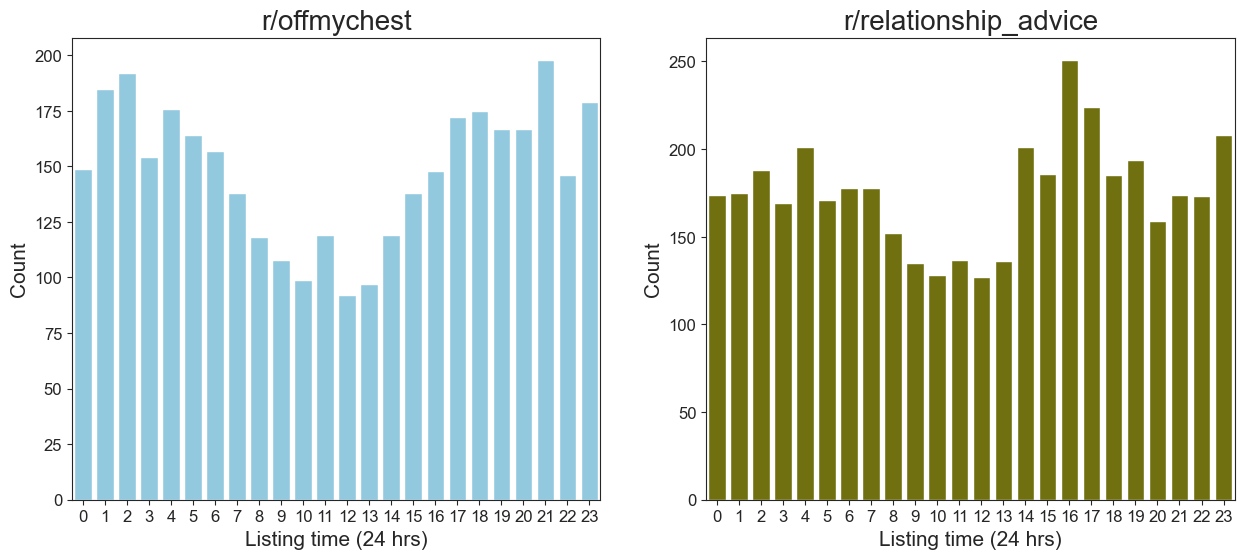

In [231]:
# let us plot the value counts for the hour of the day at which each posting is posted
#plt.figure(figsize=(8,8))
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# plot 1
sns.countplot(data=df[df['subreddit'] == 'offmychest'], x='posting_hr', color='skyblue', ax=ax[0])
ax[0].set_title('r/offmychest', size=20)
ax[0].set_xlabel("Listing time (24 hrs)", fontsize=15)
ax[0].set_ylabel("Count", fontsize=15)

# plot 2
sns.countplot(data=df[df['subreddit'] == 'relationship_advice'], x='posting_hr', color='olive', ax=ax[1])
ax[1].set_title('r/relationship_advice', size=20)
ax[1].set_xlabel("Listing time (24 hrs)", fontsize=15)
ax[1].set_ylabel("Count", fontsize=15)

for ax in ax:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

#plt.tight_layout()

Looking at the overall trend of the number of listing vs listing time, we can say both of the subreddits follow a similar trend and there is not much to separate them here. Also, it should be noted that this data is been collected in a span of a week and such a short time will not be the best representative of the time. For the same reason, we did not use the day of the week data we extracted from the columns. 

### Count the number of words

In [232]:
# create new columns with the number of words in text and titles
df['count_text'] = df['text'].apply(lambda x: len(re.findall(r'(?u)\b\w\w+\b', x)))
df['count_title'] = df['title'].apply(lambda x: len(re.findall(r'(?u)\b\w\w+\b', x)))
df.head(5)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day,count_text,count_title
0,\nI have been with the most loving caring man ...,He(18M) broke up with me(18F) over text and i ...,18s2ejz,1.703689e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,14,2,616,15
1,i’ll get the frick over it though. i am strong...,pretty sure i’m going through a mild depression,18q4ehr,1.703454e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,21,6,79,6
2,Just to note there is discussion on sensitive ...,I’m becoming all the things in my past I’ve gr...,18mvf1c,1.703081e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,14,2,282,11
3,35F - 59M - Pregnancy after prostate cancer.\n...,Pregnancy after prostate cancer. 35F - 59M.,18rb1aj,1.703606e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,15,1,429,6
4,"I met a girl name “A” on Yubo About August 18,...",I miss you.,18njdi3,1.703152e+09,https://www.reddit.com/r/offmychest/comments/1...,offmychest,9,3,1142,2


In [233]:
# average number of words in text and title for different categories
df.groupby('subreddit').mean()[['count_text', 'count_title']]

C:\Users\masou\AppData\Local\Temp\ipykernel_17424\2696699415.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('subreddit').mean()[['count_text', 'count_title']]


,count_text,count_title
subreddit,,
offmychest,291.441664,8.046669
relationship_advice,388.002379,14.124881


In [234]:
#df[['count_text', 'count_title']].describe()
df.groupby(['subreddit'], as_index=False).agg({'count_text':['min', 'max','mean'],'count_title':['min', 'max','mean']})

subreddit count_text                   count_title               
                              min   max        mean         min max       mean
0           offmychest          1  3574  291.441664           1  52   8.046669
1  relationship_advice          0  3676  388.002379           2  62  14.124881

As we can see, the number of words in the body of text and also the title for the relationship_advice subreddit is almost 25% larger than that of the offmychest subreddit. The same trend is observed for the title count. Now, let us plot distribution of the number of words for each of the subreddits. 

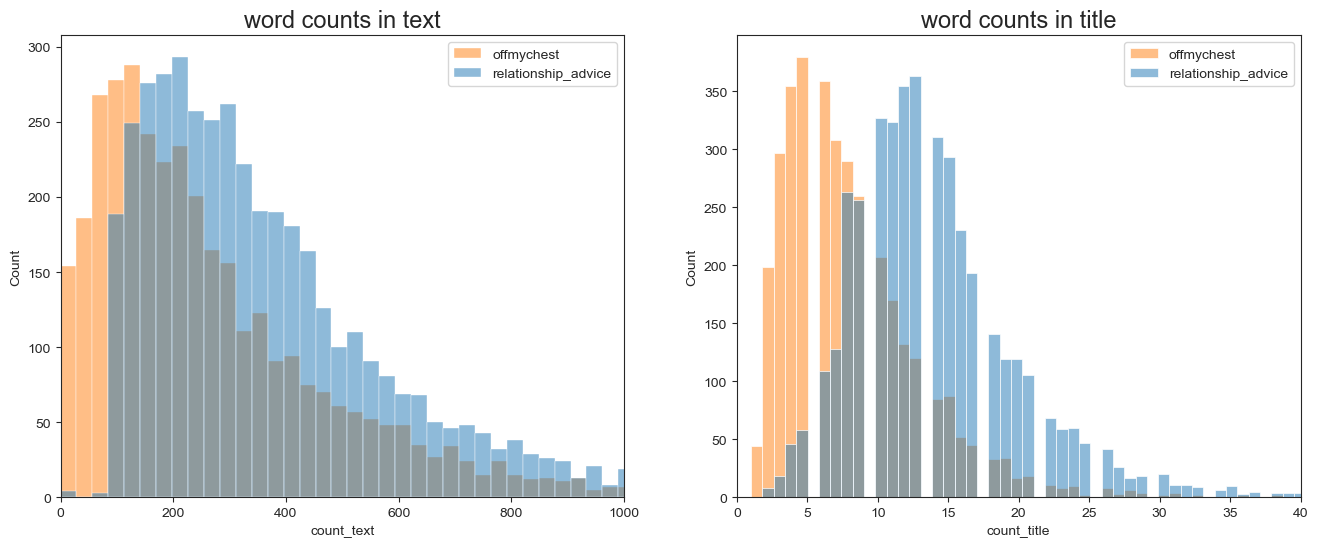

In [235]:
# distribution of the words for each of the subreddits, in the text and title of the listings. 
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.histplot(data=df, x='count_text', hue='subreddit', ax=axs[0])
axs[0].legend(['offmychest', 'relationship_advice'])
axs[0].set_title('word counts in text', size=17)
axs[0].set_xlim([0, 1000])

sns.histplot(data=df, x='count_title', hue='subreddit', ax=axs[1])
axs[1].legend(['offmychest', 'relationship_advice'])
axs[1].set_title('word counts in title', size=17)
axs[1].set_xlim([0, 40]);

The distribution graphs also show that the words count in both title and text of the postings in the relationship advice subreddit is more than that of the offmychest subreddit. This features can be used later to help categorize our listings. 

### Sentiment analysis of the text and comparing the scores
In this section, we will use sentiment analysis tools to evaluate the sentiment of the sentences and see if there is any relation between the sentiments and the subreddit.

In [236]:
# instantiate the sentiment analyzer
sent = SentimentIntensityAnalyzer()

In [237]:
# combine the title and text of the listing
# get a sentiment compound score
df['sentiment'] = df.apply(lambda x: 
                           sent.polarity_scores(x['text']+x['title'])['compound'],
                           axis=1)

In [238]:
df.head(1)

,text,title,listingid,created,url,subreddit,posting_hr,posting_day,count_text,count_title,sentiment
0,\nI have been with the most loving caring man ...,He(18M) broke up with me(18F) over text and i ...,18s2ejz,1.703689e+09,https://www.reddit.com/r/relationship_advice/c...,relationship_advice,14,2,616,15,0.9493


In [239]:
df.groupby(['subreddit'], as_index=False).agg({'sentiment':['min', 'max','mean']})

subreddit sentiment                  
                             min     max      mean
0           offmychest   -0.9998  0.9999 -0.076784
1  relationship_advice   -0.9994  0.9999  0.318352

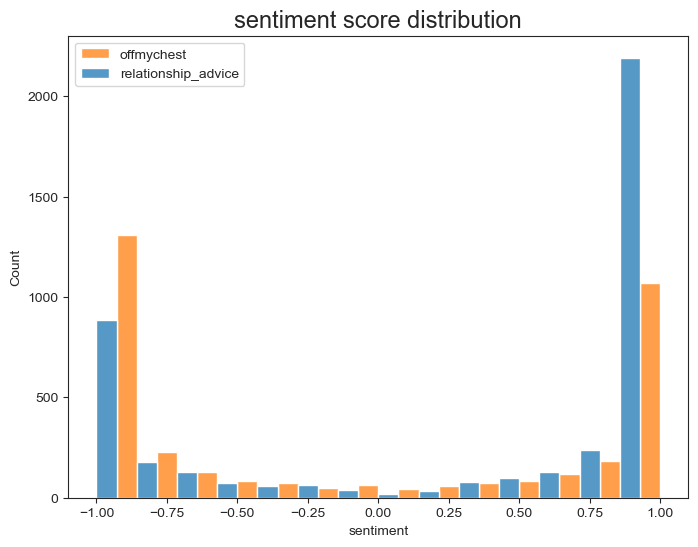

In [240]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='sentiment', hue='subreddit', multiple='dodge')
plt.legend(['offmychest', 'relationship_advice'])
plt.title('sentiment score distribution', size=17);

It is clear from the graph and also from the table that the sentiment of words in the relationship_advice subreddit is more towards the positive sentiment while that of the offmychest tends to be on the negative side. Looking at the nature of the latter one, it was predictable to get such results. These sentiment scores could later be used in our classification algorithms. 

### Word analysis with CountVectorizer

In this section, we will try to analyze the words in each of the subreddit listings and see what sort of information can we extract from it. 

In [241]:
# let us first create a df with vectorized words
df['text_title'] = df.apply(lambda x: x['text'] + x['title'] ,axis=1)
df_vectorized = df['text_title']
df_vectorized.head(3)

0    \nI have been with the most loving caring man ...
1    i’ll get the frick over it though. i am strong...
2    Just to note there is discussion on sensitive ...
Name: text_title, dtype: object

In [242]:
# create a countvectorizer object and use it to vectorize the column
cvec = CountVectorizer(stop_words='english')
# note that df_vectorized should not be a matrix or dataframe here, it 
# should be vector or a series
cvec.fit(df_vectorized)
df_vectorized = cvec.transform(df_vectorized)
# convert df_vetorized to dataframe with all new features
df_vectorized = pd.DataFrame(df_vectorized.todense(), 
                             columns=cvec.get_feature_names_out())
print(df_vectorized.shape)
df_vectorized.head(3)


(7761, 29947)


,00,000,000pesos,00am,00pm,01,0100,02,0200,03,...,zoophile,zopiclone,zuko,zyada,zzz,zzzzzzt,zzzzzzzzt,îs,μy,ні
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
# let us create two extra dataframes based on subreddits as well
df_vec_offmychest = df_vectorized[df['subreddit'] == 'offmychest']
df_vec_relationship = df_vectorized[df['subreddit'] == 'relationship_advice']
print(df_vec_offmychest.shape)
print(df_vec_relationship.shape)

(3557, 29947)
(4204, 29947)


To begin with, we will start analyzing the words in both of the subreddits.

In [244]:
df_vectorized.sum().sort_values(ascending=False).head(20)

just            17983
like            16435
don             12550
know            10728
feel            10504
time            10327
want             9698
ve               9117
really           7892
said             7149
relationship     6983
told             6495
things           6462
didn             6401
friends          5692
years            5620
think            5418
got              5346
going            5013
family           5006
dtype: int64

Looking at this data, we can find words like 'feel', 'like', 'relationship', 'friends', 'family' occur more frequently and it makes sense to see these words more often in the context of the subreddits we are investigating. Let us be more specific and look at r/offmychest and r/relationship_advice separately and see if we can find any common popular words there.  

In [245]:
# 20 most popular words in offmychest subreddit
df_vec_offmychest.sum().sort_values(ascending=False).head(20)

just       7920
like       6548
don        5221
feel       4477
know       4221
time       3701
ve         3625
want       3607
really     2962
life       2599
people     2547
got        2382
didn       2347
think      2206
friends    2129
things     2124
family     2113
years      2080
told       2001
said       1963
dtype: int64

In [246]:
# 20 most popular words in relationship_advice subreddit
df_vec_relationship.sum().sort_values(ascending=False).head(20)

just            10063
like             9887
don              7329
time             6626
know             6507
want             6091
feel             6027
relationship     5545
ve               5492
said             5186
really           4930
told             4494
things           4338
didn             4054
friends          3563
years            3540
think            3212
going            3146
love             3087
got              2964
dtype: int64

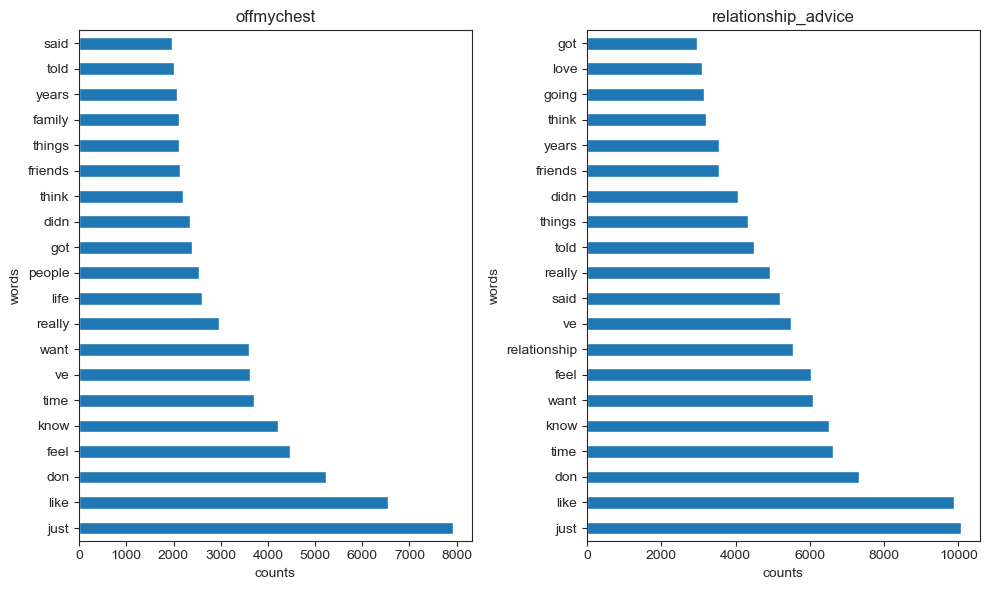

In [254]:
# let us plot the word counts side by side
fig, axs = plt.subplots(1, 2, figsize= (10,6))
df_vec_offmychest.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[0])
axs[0].set_title('offmychest')
axs[0].set_xlabel('counts')
axs[0].set_ylabel('words')

df_vec_relationship.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[1])
axs[1].set_title('relationship_advice')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('words')

fig.tight_layout()

Looking at this graph, we can say there are some words that exist numerously in both of the subreddits, e.g. 'just', 'like', 'don', 'time', 'feel', etc. These words will not help us that much while using NLP to categorize listings, and most likely we can get rid of them during the tokenizing process by excluding the words that exist in large portions of our data. On the other hand, we can see words like 'life', 'people', 'family' that are amongst the most popular words in the offmychest subreddit but not in the relationship_advice. Words like 'relationship', 'love', 'told', 'said' are shown up in the most popular words of the relationship_advice subreddit but are not among that of offmychest.

Now, let us do similar analysis but this time with bigrams (combination of two words instead of single words).

In [259]:
df_vectorized_bigram = df['text_title']
cvec_bigram = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=1000)
# note that max_features 1000 was used here as no limit for this would have caused some memory issues with bigrams. 
cvec_bigram.fit(df_vectorized_bigram)
df_vectorized_bigram = cvec_bigram.transform(df_vectorized_bigram)
# convert df_vetorized to dataframe with all new features
df_vectorized_bigram = pd.DataFrame(df_vectorized_bigram.todense(), 
                                    columns=cvec_bigram.get_feature_names_out())
df_vectorized_bigram.shape

(7761, 1000)

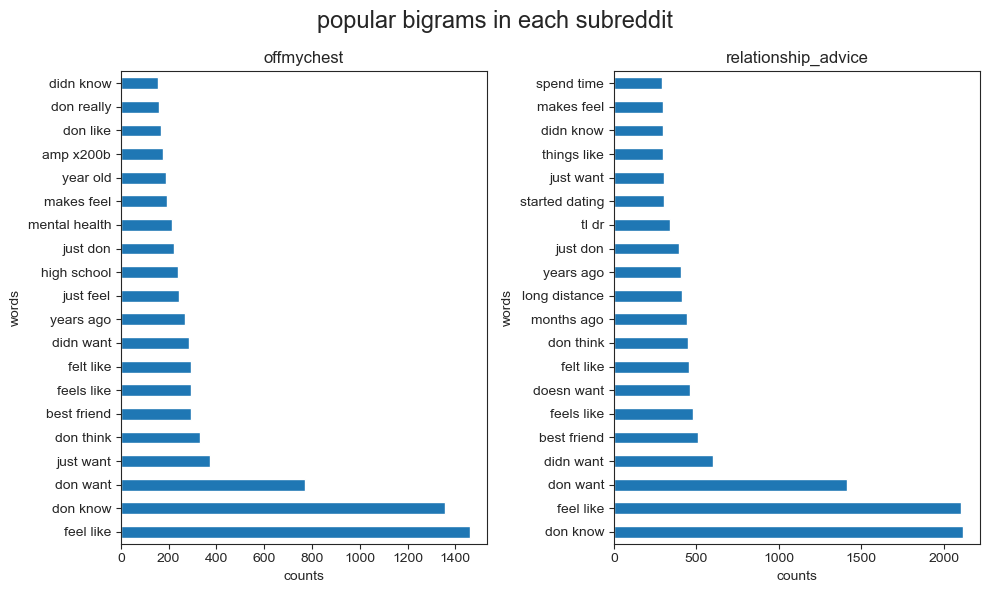

In [262]:
# let us create two extra dataframes based on subreddits as well
df_vec_offmychest_bigram = df_vectorized_bigram[df['subreddit'] == 'offmychest']
df_vec_relationship_bigram = df_vectorized_bigram[df['subreddit'] == 'relationship_advice']

# let us plot the word counts side by side
fig, axs = plt.subplots(1, 2, figsize= (10,6))
fig.suptitle('popular bigrams in each subreddit', fontsize = 17)
df_vec_offmychest_bigram.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[0])
axs[0].set_title('offmychest')
axs[0].set_xlabel('counts')
axs[0].set_ylabel('words')

df_vec_relationship_bigram.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=axs[1])
axs[1].set_title('relationship_advice')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('words')

fig.tight_layout()

Bigram analysis in this case does not add that much of information to us as a big portion of popular bigrams are terms like don't 'verb'. The interesting points are presence of words like 'mental health', 'best friend' in offmychest subreddit and words like 'long distance' and 'started dating' in relationship_advice subreddit. 